In [ ]:
!pip install -q swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 830.9/830.9 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.5 MB/s eta 0:00:00


In [ ]:
#!wget https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_GroundTruth.csv
#!wget https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Input.zip

--2023-05-23 15:13:45--  https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_GroundTruth.csv
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.216.200.99, 3.5.19.181, 52.217.230.97, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.216.200.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1291479 (1.2M) [text/csv]
Saving to: ‘ISIC_2019_Training_GroundTruth.csv.1’

ISIC_2019_Training_ 100%[===================>]   1.23M  3.29MB/s    in 0.4s    

2023-05-23 15:13:46 (3.29 MB/s) - ‘ISIC_2019_Training_GroundTruth.csv.1’ saved [1291479/1291479]

--2023-05-23 15:13:46--  https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Input.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 54.231.204.41, 54.231.225.89, 52.216.134.211, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.ama

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TRAIN_DIR='/content/drive/MyDrive/ISIC_2019'
IMG_SIZE = 224

# UNZIP File

In [ ]:
!unzip /content/drive/MyDrive/ISIC_2019/ISIC_2019_Training_Input.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: ISIC_2019_Training_Input/ISIC_0065357.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0065358.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0065359.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0065360.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0065361.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0065362.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0065366.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0065367.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0065368.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0065370.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0065371.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0065372.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0065374.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0065376.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0065377.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_0065378.jpg  
  inflating: ISIC_2019_Traini

# Import Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
import tensorflow as tf

import re
import swifter

from sklearn.model_selection import train_test_split

# Read Dataset

In [ ]:
df = pd.read_csv(os.path.join(TRAIN_DIR, 'ISIC_2019_Training_GroundTruth.csv'))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   25331 non-null  object 
 1   MEL     25331 non-null  float64
 2   NV      25331 non-null  float64
 3   BCC     25331 non-null  float64
 4   AK      25331 non-null  float64
 5   BKL     25331 non-null  float64
 6   DF      25331 non-null  float64
 7   VASC    25331 non-null  float64
 8   SCC     25331 non-null  float64
 9   UNK     25331 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.9+ MB


In [ ]:
df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df['UNK'].any()

False

--


### Convert one-hot encoded to categorical column

In [ ]:
def convert_one_hot_encoded_to_categorical(x):
    if x['MEL'] == 1:
        return 'MEL'
    elif x['NV'] == 1:
        return 'NV'
    elif x['BCC'] == 1:
        return 'BCC'
    elif x['AK'] == 1:
        return 'AK'
    elif x['BKL'] == 1:
        return 'BKL'
    elif x['DF'] == 1:
        return 'DF'
    elif x['VASC'] == 1:
        return 'VASC'
    elif x['SCC'] == 1:
        return 'SCC'
    else:
        return 'UNK'

In [ ]:
df = df.assign(target=df.swifter.apply(convert_one_hot_encoded_to_categorical, axis = 1))

Pandas Apply:   0%|          | 0/25331 [00:00<?, ?it/s]

### Check if an image is missing

In [ ]:
def check_if_missing(x):
    return not os.path.exists(
        os.path.join(
            TRAIN_DIR,
            '/content/ISIC_2019_Training_Input',
            '/content/ISIC_2019_Training_Input',
            x + ".jpg"
        )
    )

In [ ]:
df['image'].swifter.apply(check_if_missing).any()

Pandas Apply:   0%|          | 0/25331 [00:00<?, ?it/s]

False

### Remove one-hot encoded columns as it's already replaced by target column

In [ ]:
# Remove all one-hot encoded columns with target column
df = df[['image', 'target']]

In [ ]:
df

,image,target
0,ISIC_0000000,NV
1,ISIC_0000001,NV
2,ISIC_0000002,MEL
3,ISIC_0000003,NV
4,ISIC_0000004,MEL
...,...,...
25326,ISIC_0073247,BCC
25327,ISIC_0073248,BKL
25328,ISIC_0073249,MEL
25329,ISIC_0073251,NV


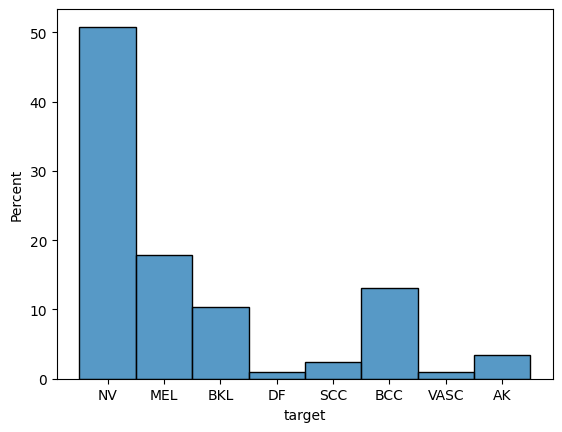

In [ ]:
sns.histplot(df, x='target', stat='percent')
plt.show()

In [ ]:
# train : val : test
# 70 : 15 : 15

# Use stratify sampling for splitting as the target variable is heavily imbalanced
df_train, df_val = train_test_split(
    df,
    stratify = df['target'],
    shuffle = True,
    random_state = 2023,
    test_size = .3
)

In [ ]:
# 0.3 x 0.5 = 0.15
df_val, df_test = train_test_split(
    df_val, 
    stratify = df_val['target'],
    shuffle = True,
    random_state = 2022,
    test_size = .5
)

### Copy images to separate directory based on previous splits

In [ ]:
def create_dir(dir):
    if not os.path.exists(dir):
        os.mkdir(dir)

def create_data_dir(mode = "train"):
    root_dir = os.path.join(
        os.getcwd(),
        mode
    )
    # delete prevously created directory otherwise it'll cause an error
    shutil.rmtree(root_dir, ignore_errors = True)
    
    
    create_dir(root_dir)
    
    for target in df['target'].unique():
        create_dir(os.path.join(root_dir, target))
            
    SOURCE_DIR = os.path.join(
        TRAIN_DIR,
        '/content/drive/MyDrive/ISIC_2019/ISIC_2019_Training_Input',
        '/content/drive/MyDrive/ISIC_2019/ISIC_2019_Training_Input'
    )
    def copy(x):
        target_dir = os.path.join(root_dir, x['target'])
        shutil.copyfile(
            os.path.join(
                SOURCE_DIR,
                x['image'] + ".jpg"
            ),
            os.path.join(
                target_dir,
                x['image'] + ".jpg"
            )
        )
        return x
    return copy

In [ ]:
df_train.swifter.apply(create_data_dir("train"), axis = 1)
df_val.swifter.apply(create_data_dir("val"), axis = 1)
df_test.swifter.apply(create_data_dir("test"), axis = 1)

Pandas Apply:   0%|          | 0/17731 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3800 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3800 [00:00<?, ?it/s]

,image,target
18289,ISIC_0062087,MEL
12962,ISIC_0053528,BKL
20071,ISIC_0064939,BCC
2814,ISIC_0015971_downsampled,NV
15713,ISIC_0057997,MEL
...,...,...
13331,ISIC_0054141,MEL
11834,ISIC_0033237,NV
23719,ISIC_0070701,BCC
7951,ISIC_0029354,NV


# Visualizing image

In [ ]:
train_dir=os.path.join(TRAIN_DIR,"train")
test_dir=os.path.join(TRAIN_DIR,"test")
train_AK_dir=os.path.join(train_dir, 'AK')
train_BCC_dir=os.path.join(train_dir, 'BCC')
#BKL_dir=os.path.join(TRAIN_DIR, 'BKL')
#DF_dir=os.path.join(TRAIN_DIR, 'DF')
#MEL_dir=os.path.join(TRAIN_DIR, 'MEL')
##NV_dir=os.path.join(TRAIN_DIR, 'NV')
#SCC_dir=os.path.join(TRAIN_DIR, 'SCC')
#VASC_dir=os.path.join(TRAIN_DIR, 'VASC')

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array

Sample AK image:


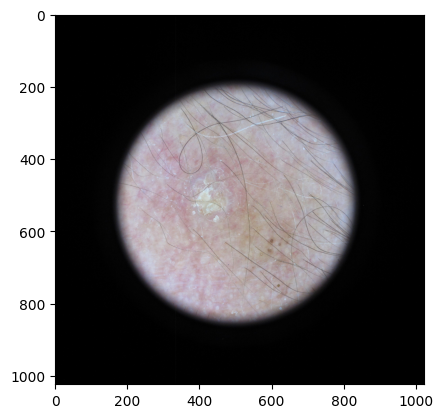

Sample BCC image:


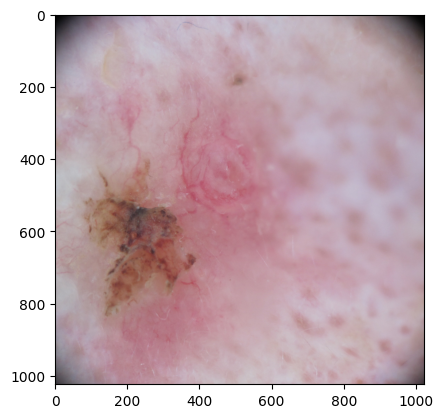

In [ ]:
print("Sample AK image:")
plt.imshow(load_img(f"{os.path.join(train_AK_dir, os.listdir(train_AK_dir)[0])}"))
plt.show()

print("Sample BCC image:")
plt.imshow(load_img(f"{os.path.join(train_BCC_dir, os.listdir(train_BCC_dir)[0])}"))
plt.show()


In [ ]:
# Load the first example of an AK
sample_image  = load_img(f"{os.path.join(train_AK_dir ,os.listdir(train_AK_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (1024, 1024, 3)
